# Open Interest Data

In [1]:
import os
import sys
import dotenv
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import kaleido

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from client.query_api_client import HelixirQueryApi

## Create Query Api Client

In [3]:
dotenv.load_dotenv(".env")
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = HelixirQueryApi(auth_token=AUTH_TOKEN, api_version="v1")
client

In [4]:
query = """WITH pair AS (
    SELECT id
    FROM cex.binance.pairs
    WHERE symbol = 'BTCUSDT'
)
SELECT timestamp as time,
       open_interest,
       open_interest_value
FROM cex.binance.open_interest_hourly, pair
WHERE timestamp > now() - interval '5' day
  and pair_id = pair.id
order by 1;"""

response = client.get_data_response(query)
response['time'] = pd.to_datetime(response['time'])
response['open_interest'] = pd.to_numeric(response['open_interest'])
response['open_interest_value'] = pd.to_numeric(response['open_interest_value'])
response

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,open_interest,open_interest_value,time
0,440498.728,9.397910e+09,2023-01-20 17:00:00+00:00
1,444263.772,9.488938e+09,2023-01-20 18:00:00+00:00
2,443904.544,9.493520e+09,2023-01-20 19:00:00+00:00
3,420738.118,9.181582e+09,2023-01-20 20:00:00+00:00
4,396337.585,8.828310e+09,2023-01-20 21:00:00+00:00
...,...,...,...
114,375298.684,8.483014e+09,2023-01-25 11:00:00+00:00
115,376071.588,8.528188e+09,2023-01-25 12:00:00+00:00
116,376477.759,8.535539e+09,2023-01-25 13:00:00+00:00
117,377419.106,8.515368e+09,2023-01-25 14:00:00+00:00


In [5]:
query = """SELECT price.bucket as time,
       close_stable as close,
       open_stable  as open,
       high_stable  as high,
       low_stable   as low,
       v.volume     as volume
FROM cex.binance.price_ticks_hourly price
         join cex.binance.pairs pairs on (price.token_id = pairs.id)
         join cex.binance.volume_ticks_hourly v
              on (price.bucket = v.bucket and price.token_id = v.token_id and price.platform_id = v.platform_id)
WHERE price.bucket > now() - interval '5' day
  and pairs.symbol = 'BTCUSDT'
ORDER BY 1;"""

tohlcv_resp = client.get_data_response(query)
tohlcv_resp['time'] = pd.to_datetime(tohlcv_resp['time'])
tohlcv_resp.set_index('time')
tohlcv_resp['open'] = pd.to_numeric(tohlcv_resp['open'])
tohlcv_resp['high'] = pd.to_numeric(tohlcv_resp['high'])
tohlcv_resp['low'] = pd.to_numeric(tohlcv_resp['low'])
tohlcv_resp['close'] = pd.to_numeric(tohlcv_resp['close'])
tohlcv_resp['volume'] = pd.to_numeric(tohlcv_resp['volume'])
tohlcv_resp

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,close,high,low,open,time,volume
0,21353.61,21410.00,21279.90,21313.29,2023-01-20 17:00:00+00:00,15591.76820
1,21384.49,21437.30,21290.57,21353.62,2023-01-20 18:00:00+00:00,16897.42332
2,21496.67,21529.00,21356.70,21385.52,2023-01-20 19:00:00+00:00,15675.31388
3,22288.37,22385.41,21841.55,21865.76,2023-01-20 20:00:00+00:00,21191.74733
4,22315.41,22361.50,22261.47,22285.87,2023-01-20 21:00:00+00:00,7052.48609
...,...,...,...,...,...,...
111,22611.90,22630.78,22475.00,22607.26,2023-01-25 10:00:00+00:00,13147.50834
112,22598.47,22628.42,22561.18,22610.91,2023-01-25 11:00:00+00:00,7114.50494
113,22694.23,22740.50,22668.40,22731.99,2023-01-25 12:00:00+00:00,3367.07470
114,22595.72,22729.99,22565.01,22694.22,2023-01-25 13:00:00+00:00,10785.18821


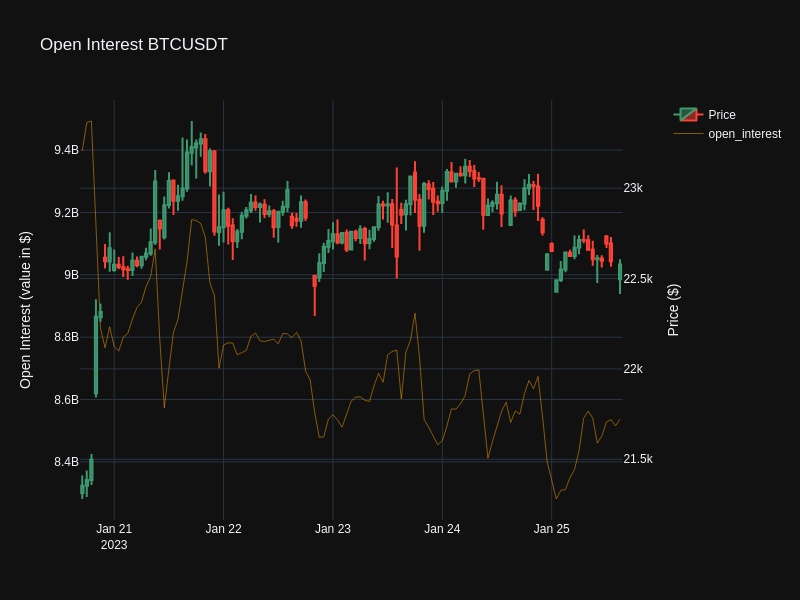

In [9]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

candlestick = go.Candlestick(
    x=tohlcv_resp['time'],
    open=tohlcv_resp['open'],
    high=tohlcv_resp['high'],
    low=tohlcv_resp['low'],
    close=tohlcv_resp['close'],
    name="Price"
)

open_interest = go.Scatter(x=response['time'],
                         y=response['open_interest_value'],
                         name="open_interest",
                         mode='lines',
                         line=dict(width=0.5, color='orange'),
                         )

fig.add_trace(candlestick, secondary_y=True)
fig.add_trace(open_interest, secondary_y=False)

fig.update_layout(
    width=800, height=600,
    title="Open Interest BTCUSDT",
    xaxis_rangeslider_visible=False
)

# Set y-axes titles
fig.update_yaxes(title_text="Open Interest (value in $)", secondary_y=False)
fig.update_yaxes(title_text="Price ($)", secondary_y=True)

fig.show("png")